In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [3]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/Kolmogorov


In [7]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories
from tools.ae_v2 import Autoencoder

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [10]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-02-16 20:58:07.355107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-02-16 20:58:07.355584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 20:58:07.430153: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 20:58:07.430451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 20:58:07.430719: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-16 20:58:07.430952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [11]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [12]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # loading data directory
    data_dir_idx = '000'

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')
else:
    # some paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_015'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_ae:', dir_name_ae)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with h5py.File(dir_name_data + '/data.h5', 'r') as f:
    t_recorded_samples = np.array(f['t'])
    
    N = int(0.5*(np.array(f['num_wavenumbers'])-1))
    print(N, type(N))
    
    u_ref = np.array(f['u_reference'], dtype=FTYPE)
    v_ref = np.array(f['v_reference'], dtype=FTYPE)

dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_012
24 <class 'int'>


In [13]:
all_data = np.empty(shape=(u_ref.shape[0], 2, u_ref.shape[1], u_ref.shape[2]), dtype=FTYPE)
all_data[:, 0, :, :] = u_ref
del(u_ref)
all_data[:, 1, :, :] = v_ref
del(v_ref)

In [14]:
# dealing with normalizing the data before feeding into autoencoder
if behaviour == 'initialiseAndTrainFromScratch':
    # normalize data before feeding into autoencoder?
    normalizeforae_flag = True
    normalization_type = 'stddev' # could be 'stddev' or 'minmax'
    stddev_multiplier = 3
    
    normalization_constant_arr_aedata = None
    if normalizeforae_flag == True:
        normalization_constant_arr_aedata = np.empty(shape=(2,) + tuple(all_data.shape[1:]), dtype=FTYPE)
        if normalization_type == 'stddev':
            normalization_constant_arr_aedata[0] = np.mean(all_data, axis=0)
            normalization_constant_arr_aedata[1] = stddev_multiplier * np.std(all_data, axis=0)
        elif normalization_type == 'minmax':
            sample_min = all_data.min(axis=0)
            sample_max = all_data.max(axis=0)
            idx = np.where(sample_min == sample_max)
            if len(idx) > 0:
                num_elems = len(idx[0])
                for i in range(num_elems):
                    i0 = idx[0][i]
                    i1 = idx[1][i]
                    i2 = idx[2][i]
                    sample_min[i0, i1, i2] -= 0.5
                    sample_max[i0, i1, i2] = sample_min[i0, i1, i2] + 1.
            normalization_constant_arr_aedata[0] = sample_min
            normalization_constant_arr_aedata[1] = sample_max - sample_min
        all_data -= normalization_constant_arr_aedata[0]
        all_data /= normalization_constant_arr_aedata[1]
            
    # saving sim data
    ae_data = {
        'data_dir_idx':data_dir_idx,
        'normalizeforae_flag':normalizeforae_flag,
        # 'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
        'normalization_type':normalization_type,
        'stddev_multiplier':stddev_multiplier,
        'ae_data_with_params':False,
        'module':Autoencoder.__module__,
    }
    with open(dir_name_ae+dir_sep+'ae_data.txt', 'w') as f:
        f.write(str(ae_data))
    np.savez(
        dir_name_ae+dir_sep+'normalization_data',
        normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
    )
else:
    if normalizeforae_flag == True:
        all_data -= normalization_constant_arr_aedata[0]
        all_data /= normalization_constant_arr_aedata[1]
            
time_stddev = np.std(all_data, axis=0)

In [15]:
all_data = all_data[::4]

# Autoencoder

In [16]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 200
    patience = 10  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 5e-7 # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 16
    fRMS = 2/100
    timeMeanofSpaceRMS = np.mean(np.mean(all_data**2, axis=1)**0.5)
    
    # stddev = fRMS*timeMeanofSpaceRMS
    stddev = fRMS * np.mean(time_stddev)
    use_weights_post_dense = False
    use_batch_norm = True

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'use_batch_norm':use_batch_norm,
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        stddev = tparams_dict['stddev']
    except:
        print("'stddev' not in tparams_dict, set to 0")
        stddev = 0.0

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [17]:
# # setting up data
# idx = np.arange(all_data.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round((1-test_split)*all_data.shape[0]))
# training_data = all_data[idx[0:boundary], :]
# testing_data = all_data[idx[boundary:], :]

In [18]:
num_train = int(all_data.shape[0]*train_split)
num_val = int(all_data.shape[0]*val_split)
num_test = all_data.shape[0] - num_train - num_val

idx = np.arange(all_data.shape[0])
np.random.shuffle(idx)

training_data = np.empty(shape=(num_train, ) + tuple(all_data.shape[1:]), dtype=FTYPE)
val_data = np.empty(shape=(num_val, ) + tuple(all_data.shape[1:]), dtype=FTYPE)
testing_data = np.empty(shape=(num_test, ) + tuple(all_data.shape[1:]), dtype=FTYPE)

training_data[:] = all_data[idx[0:num_train]]
val_data[:] = all_data[idx[num_train:num_train+num_val]]
testing_data[:] = all_data[idx[num_train+num_val:]]

In [19]:
del(all_data)

In [20]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    enc_filters = [8, 3, 1]
    enc_strides = [2, 1, 1]
    enc_attn_placement = [1]
    dec_filters = [3, 8, 2]
    dec_strides = [1, 1, 2]
    dec_attn_placement = [0]
    kernel_size = 5
    
    enc_layer_act_func = 'elu'
    enc_final_layer_act_func = 'tanh'
    dec_layer_act_func = 'elu'
    dec_final_layer_act_func = 'tanh'
    reg_name = 'L2'
    
    use_periodic_padding = True
    use_attention_module = True
    
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(
                data_dim=training_data.shape[1:],
                kernel_size=kernel_size,
                enc_filters=enc_filters, # number of filters
                dec_filters=dec_filters, # number of filters
                lambda_reg=lambda_reg,
                reg_name=reg_name,
                enc_layer_act_func=enc_layer_act_func,
                enc_final_layer_act_func=enc_final_layer_act_func,
                dec_layer_act_func=dec_layer_act_func,
                dec_final_layer_act_func=dec_final_layer_act_func,
                load_file=None,
                stddev=stddev,
                use_weights_post_dense=use_weights_post_dense,
                use_batch_norm=use_batch_norm,
                use_periodic_padding=use_periodic_padding,
                use_attention_module=use_attention_module,
                enc_strides=enc_strides,
                enc_attn_placement=enc_attn_placement,
                dec_strides=dec_strides,
                dec_attn_placement=dec_attn_placement,)
    else:
        ae_net = Autoencoder(
            data_dim=training_data.shape[1:],
            kernel_size=kernel_size,
            enc_filters=enc_filters, # number of filters
            dec_filters=dec_filters, # number of filters
            lambda_reg=lambda_reg,
            reg_name=reg_name,
            enc_layer_act_func=enc_layer_act_func,
            enc_final_layer_act_func=enc_final_layer_act_func,
            dec_layer_act_func=dec_layer_act_func,
            dec_final_layer_act_func=dec_final_layer_act_func,
            load_file=None,
            stddev=stddev,
            use_weights_post_dense=use_weights_post_dense,
            use_batch_norm=use_batch_norm,
            use_periodic_padding=use_periodic_padding,
            use_attention_module=use_attention_module,
            enc_strides=enc_strides,
            enc_attn_placement=enc_attn_placement,
            dec_strides=dec_strides,
            dec_attn_placement=dec_attn_placement,)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(data_dim=training_data.shape[1:], load_file=load_file)
    else:
        ae_net = Autoencoder(data_dim=training_data.shape[1:], load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ae+dir_sep+'checkpoints')
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
        ae_net.load_weights_from_file(wt_file)

2023-02-16 20:58:16.967441: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401


In [21]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [22]:
train_MSE_hist = []
val_MSE_hist = []

train_NMSE_hist = []
val_NMSE_hist = []

if use_attention_module == True:
    encoder_attention_lambdas = {}
    for i in range(len(ae_net.encoder_attention_modules_list)):
        l = ae_net.encoder_attention_modules_list[i]
        encoder_attention_lambdas['encoder_attention_module_{}_lambda'.format(i)] = [0]
    decoder_attention_lambdas = {}
    for i in range(len(ae_net.decoder_attention_modules_list)):
        l = ae_net.decoder_attention_modules_list[i]
        decoder_attention_lambdas['decoder_attention_module_{}_lambda'.format(i)] = [0]

In [23]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [24]:
if strategy is not None:
    with strategy.scope():
        NMSE_metric = NMSE(divisor_arr=tf.constant(time_stddev))
else:
    NMSE_metric = NMSE(divisor_arr=tf.constant(time_stddev))

In [25]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
#     loss=losses.BinaryCrossentropy(from_logits=False),
    run_eagerly=False,
    metrics=['mse', NMSE_metric]
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            ae_net.load_weights(wt_file)
    else:
        ae_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=1  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data, val_data),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        val_MSE_hist.extend(history.history['val_mse'])
        train_MSE_hist.extend(history.history['mse'])
        
        val_NMSE_hist.extend(history.history['val_NMSE'])
        train_NMSE_hist.extend(history.history['NMSE'])
        
        if use_attention_module == True:
            for j in range(len(ae_net.encoder_attention_modules_list)):
                key = 'encoder_attention_module_{}_lambda'.format(j)
                lst1 = history.history[key]
                lst2 = encoder_attention_lambdas[key]
                lst2.extend(lst1)
                encoder_attention_lambdas[key] = lst2
            for j in range(len(ae_net.decoder_attention_modules_list)):
                key = 'decoder_attention_module_{}_lambda'.format(j)
                lst1 = history.history[key]
                lst2 = decoder_attention_lambdas[key]
                lst2.extend(lst1)
                decoder_attention_lambdas[key] = lst2
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
1249/1250 [============================>.] - ETA: 0s - loss: 0.0367 - mse: 0.0367 - NMSE: 0.3303 - encoder_attention_module_0_lambda: -0.1124 - decoder_attention_module_0_lambda: -0.0624 - tot_time: 0h 0m 49.1s

Epoch 1: val_NMSE improved from inf to 0.09376, saving model to /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_012/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_012/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 48s 37ms/step - loss: 0.0367 - mse: 0.0367 - NMSE: 0.3302 - encoder_attention_module_0_lambda: -0.1125 - decoder_attention_module_0_lambda: -0.0624 - val_loss: 0.0104 - val_mse: 0.0104 - val_NMSE: 0.09

Epoch 12/200
1249/1250 [============================>.] - ETA: 0s - loss: 8.3994e-04 - mse: 8.2808e-04 - NMSE: 0.0075 - encoder_attention_module_0_lambda: -0.1808 - decoder_attention_module_0_lambda: -0.3241 - tot_time: 0h 9m 11.8s

Epoch 12: val_NMSE did not improve from 0.01836
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_012/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 46s 37ms/step - loss: 8.3987e-04 - mse: 8.2802e-04 - NMSE: 0.0075 - encoder_attention_module_0_lambda: -0.1808 - decoder_attention_module_0_lambda: -0.3241 - val_loss: 0.0306 - val_mse: 0.0306 - val_NMSE: 0.2754
Epoch 13/200
1249/1250 [============================>.] - ETA: 0s - loss: 8.1038e-04 - mse: 7.9832e-04 - NMSE: 0.0072 - encoder_attention_module_0_lambda: -0.1854 - decoder_attention_module_0_lambda: -0.3591 - tot_time: 0h 9m 57.5s

Epoch 13: val_NMSE did not improve from 0.01836
 - saving loss histories at /home/rkaushik/Documents

1249/1250 [============================>.] - ETA: 0s - loss: 7.1202e-04 - mse: 6.9755e-04 - NMSE: 0.0063 - encoder_attention_module_0_lambda: -0.3069 - decoder_attention_module_0_lambda: -0.4330 - tot_time: 0h 18m 14.9s

Epoch 24: val_NMSE did not improve from 0.01133
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_012/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 45s 36ms/step - loss: 7.1205e-04 - mse: 6.9757e-04 - NMSE: 0.0063 - encoder_attention_module_0_lambda: -0.3069 - decoder_attention_module_0_lambda: -0.4330 - val_loss: 0.0113 - val_mse: 0.0113 - val_NMSE: 0.1015
Epoch 25/200
1249/1250 [============================>.] - ETA: 0s - loss: 7.0040e-04 - mse: 6.8573e-04 - NMSE: 0.0062 - encoder_attention_module_0_lambda: -0.3161 - decoder_attention_module_0_lambda: -0.4348 - tot_time: 0h 18m 59.8s

Epoch 25: val_NMSE did not improve from 0.01133
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLR

1249/1250 [============================>.] - ETA: 0s - loss: 6.7550e-04 - mse: 6.5906e-04 - NMSE: 0.0059 - encoder_attention_module_0_lambda: -0.3341 - decoder_attention_module_0_lambda: -0.4634 - tot_time: 0h 27m 13.8s

Epoch 36: val_NMSE did not improve from 0.01131
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_012/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 45s 36ms/step - loss: 6.7577e-04 - mse: 6.5932e-04 - NMSE: 0.0059 - encoder_attention_module_0_lambda: -0.3341 - decoder_attention_module_0_lambda: -0.4634 - val_loss: 0.0025 - val_mse: 0.0025 - val_NMSE: 0.0226
Epoch 37/200
1249/1250 [============================>.] - ETA: 0s - loss: 6.5601e-04 - mse: 6.3941e-04 - NMSE: 0.0058 - encoder_attention_module_0_lambda: -0.3378 - decoder_attention_module_0_lambda: -0.4658Restoring model weights from the end of the best epoch: 27.
 - tot_time: 0h 27m 58.5s

Epoch 37: val_NMSE did not improve from 0.01131
 - 

Epoch 10/200
1249/1250 [============================>.] - ETA: 0s - loss: 6.4860e-04 - mse: 6.3374e-04 - NMSE: 0.0057 - encoder_attention_module_0_lambda: -0.3153 - decoder_attention_module_0_lambda: -0.4467 - tot_time: 0h 35m 27.3s

Epoch 10: val_NMSE did not improve from 0.00392
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_012/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 45s 36ms/step - loss: 6.4842e-04 - mse: 6.3356e-04 - NMSE: 0.0057 - encoder_attention_module_0_lambda: -0.3153 - decoder_attention_module_0_lambda: -0.4467 - val_loss: 5.9262e-04 - val_mse: 5.7778e-04 - val_NMSE: 0.0052
Epoch 11/200
1249/1250 [============================>.] - ETA: 0s - loss: 6.4202e-04 - mse: 6.2719e-04 - NMSE: 0.0056 - encoder_attention_module_0_lambda: -0.3136 - decoder_attention_module_0_lambda: -0.4475 - tot_time: 0h 36m 11.9s

Epoch 11: val_NMSE did not improve from 0.00392
 - saving loss histories at /home/rkaushik

Epoch 9/200
1249/1250 [============================>.] - ETA: 0s - loss: 6.3702e-04 - mse: 6.2197e-04 - NMSE: 0.0056 - encoder_attention_module_0_lambda: -0.3231 - decoder_attention_module_0_lambda: -0.4440 - tot_time: 0h 43m 39.8s

Epoch 9: val_NMSE did not improve from 0.00372
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/Kolmogorov/saved_ae/ae_012/checkpoints/LossHistoriesCheckpoint
1250/1250 [==============================] - 45s 36ms/step - loss: 6.3687e-04 - mse: 6.2183e-04 - NMSE: 0.0056 - encoder_attention_module_0_lambda: -0.3231 - decoder_attention_module_0_lambda: -0.4440 - val_loss: 4.3668e-04 - val_mse: 4.2164e-04 - val_NMSE: 0.0038
Epoch 10/200
1249/1250 [============================>.] - ETA: 0s - loss: 6.4878e-04 - mse: 6.3374e-04 - NMSE: 0.0057 - encoder_attention_module_0_lambda: -0.3229 - decoder_attention_module_0_lambda: -0.4440 - tot_time: 0h 44m 24.5s

Epoch 10: val_NMSE did not improve from 0.00372
 - saving loss histories at /home/rkaushik/D

In [26]:
ae_net.encoder_net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 50, 50)]       0         
                                                                 
 gaussian_noise (GaussianNoi  (None, 2, 50, 50)        0         
 se)                                                             
                                                                 
 periodic_padding (periodic_  (None, 2, 54, 54)        5400      
 padding)                                                        
                                                                 
 conv2d (Conv2D)             (None, 8, 25, 25)         400       
                                                                 
 batch_normalization (BatchN  (None, 8, 25, 25)        32        
 ormalization)                                                   
                                                             

In [27]:
ae_net.decoder_net.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 25, 25)]       0         
                                                                 
 periodic_padding_3 (periodi  (None, 1, 29, 29)        1450      
 c_padding)                                                      
                                                                 
 conv2d_transpose (Conv2DTra  (None, 3, 33, 33)        75        
 nspose)                                                         
                                                                 
 cropping2d (Cropping2D)     (None, 3, 25, 25)         0         
                                                                 
 batch_normalization_3 (Batc  (None, 3, 25, 25)        12        
 hNormalization)                                                 
                                                           

In [28]:
ae_net.ae_net.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2, 50, 50)]       0         
                                                                 
 model (Functional)          (None, 1, 25, 25)         9460      
                                                                 
 model_1 (Functional)        (None, 2, 50, 50)         5514      
                                                                 
Total params: 14,974
Trainable params: 2,274
Non-trainable params: 12,700
_________________________________________________________________


In [29]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_metrics = ae_net.evaluate(
        testing_data, testing_data,
    )
#     train_metrics = ae_net.evaluate(training_data, training_data)
#     val_metrics = ae_net.evaluate(val_data, val_data)

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    save_dict = {
        'val_loss_hist':val_loss_hist,
        'train_loss_hist':train_loss_hist,
        'val_MSE_hist':val_MSE_hist,
        'train_MSE_hist':train_MSE_hist,
        'val_NMSE_hist':val_NMSE_hist,
        'train_NMSE_hist':train_NMSE_hist,
        'lr_change':lr_change,
        'test_loss':test_metrics[0],
        'test_mse':test_metrics[1],
#         'train_loss':train_metrics[0],
#         'train_mse':train_metrics[1],
#         'val_loss':val_metrics[0],
#         'val_mse':val_metrics[1],
    }
    if use_attention_module == True:
        for i in range(len(ae_net.encoder_attention_modules_list)):
            key = 'encoder_attention_module_{}_lambda'.format(i)
            save_dict[key] = encoder_attention_lambdas[key]
        for i in range(len(ae_net.decoder_attention_modules_list)):
            key = 'decoder_attention_module_{}_lambda'.format(i)
            save_dict[key] = decoder_attention_lambdas[key]

    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str(save_dict))

    np.savez(
        save_path+dir_sep+'losses',
        **save_dict
    )
        

    ae_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

79/79 [==============================] - 2s 24ms/step - loss: 4.4656e-04 - mse: 4.3149e-04 - NMSE: 0.0039


In [30]:
print('lr_change : ', lr_change)

lr_change :  [0, 37, 49, 62]


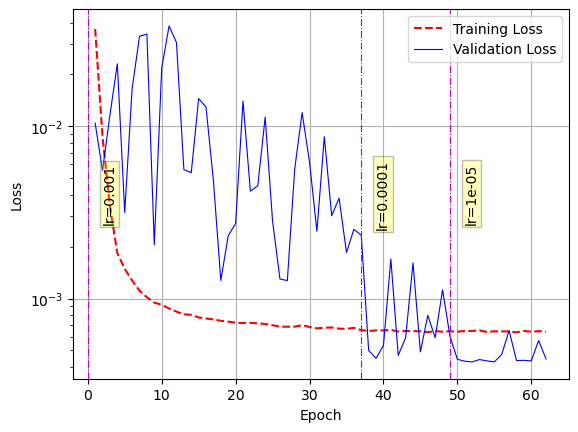

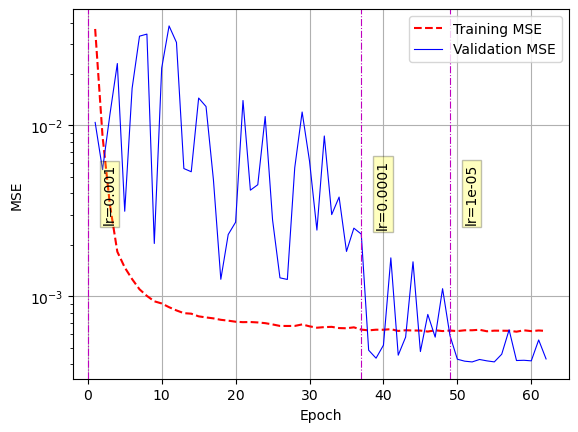

<Figure size 640x480 with 0 Axes>

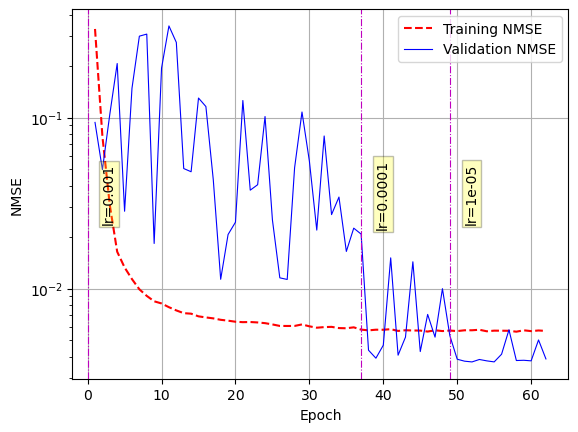

<Figure size 640x480 with 0 Axes>

In [31]:
# plotting losses
dir_name_plot = dir_name_ae + '/plots'
if not os.path.isdir(dir_name_plot):
    os.makedirs(dir_name_plot)

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_plot + '{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plot_losses(
    training_loss=train_MSE_hist,
    val_loss=val_MSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training MSE', 'Validation MSE'],
    xlabel='Epoch',
    ylabel='MSE',
)
plt.savefig(dir_name_plot+'/MSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()


fig, ax = plot_losses(
    training_loss=train_NMSE_hist,
    val_loss=val_NMSE_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list,
    legend_list=['Training NMSE', 'Validation NMSE'],
    xlabel='Epoch',
    ylabel='NMSE',
)
plt.savefig(dir_name_plot+'/NMSE_history.png', dpi=300, bbox_inches='tight')
plt.show()
plt.clf()

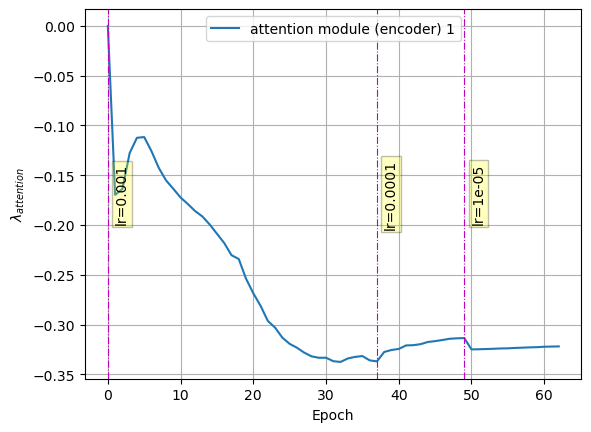

<Figure size 640x480 with 0 Axes>

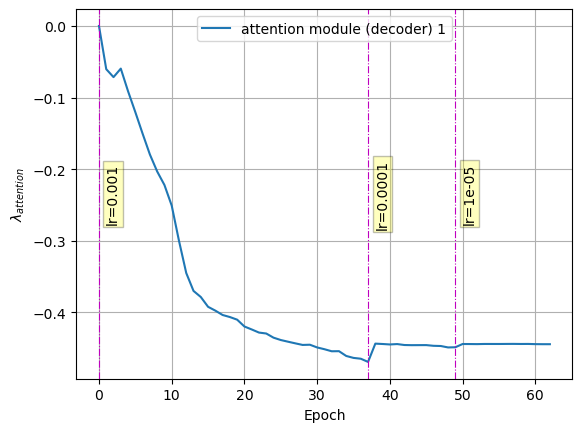

<Figure size 640x480 with 0 Axes>

In [34]:
if use_attention_module == True:
    # plotting encoder attention lambdas
    plot_lst = []
    legend_lst = []
    for i in range(len(ae_net.encoder_attention_modules_list)):
        key = 'encoder_attention_module_{}_lambda'.format(i)
        plot_lst.append(encoder_attention_lambdas[key])
        legend_lst.append("attention module (encoder) {}".format(i+1))
    fig, ax = plot_losses(
        training_loss=plot_lst[0],
        val_loss=None,
        more_plot_arrs_lst=plot_lst[1:] if len(plot_lst)>1 else [],
        lr_change=lr_change,
        learning_rate_list=learning_rate_list,
        legend_list=legend_lst,
        xlabel='Epoch',
        ylabel=r"$\lambda_{attention}$",
        plot_type='plot',
        traininglossplot_args=[],
        traininglossplot_kwargs={},
        epoch_count_begin=0,
        epoch_count_end=len(plot_lst[0])-1,
    )
    plt.savefig(dir_name_plot+'/attention_lambdas_encoder.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()
    
    # plotting decoder attention lambdas
    plot_lst = []
    legend_lst = []
    for i in range(len(ae_net.decoder_attention_modules_list)):
        key = 'decoder_attention_module_{}_lambda'.format(i)
        plot_lst.append(decoder_attention_lambdas[key])
        legend_lst.append("attention module (decoder) {}".format(i+1))
    fig, ax = plot_losses(
        training_loss=plot_lst[0],
        val_loss=None,
        more_plot_arrs_lst=plot_lst[1:] if len(plot_lst)>1 else [],
        lr_change=lr_change,
        learning_rate_list=learning_rate_list,
        legend_list=legend_lst,
        xlabel='Epoch',
        ylabel=r"$\lambda_{attention}$",
        plot_type='plot',
        traininglossplot_args=[],
        traininglossplot_kwargs={},
        epoch_count_begin=0,
        epoch_count_end=len(plot_lst[0])-1,
    )
    plt.savefig(dir_name_plot+'/attention_lambdas_decoder.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.clf()

# POD Comparison

In [35]:
# pod_training_data = np.empty(shape=(training_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]))
# pod_training_data[:, :] = np.reshape(training_data, (training_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]))

# pod_centering_means = np.mean(pod_training_data, axis=0)
# pod_mean_centered_data = pod_training_data - pod_centering_means

In [36]:
# C = np.transpose(pod_mean_centered_data) @ pod_mean_centered_data
# C /= pod_mean_centered_data.shape[0] - 1

In [37]:
# eigenvals, eigenvecs = np.linalg.eig(C)

In [38]:
# abs_eigenvals = np.abs(eigenvals)
# idx = np.argsort(abs_eigenvals)

In [39]:
# idx = idx[::-1]
# W = eigenvecs[:, idx[0:4*4*enc_filters[-1]]]

In [40]:
# reconstructed_val_data = val_data.reshape(val_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]) @ W @ W.transpose()
# reconstructed_val_data = np.reshape(reconstructed_val_data, val_data.shape)

In [41]:
# val_recon_MSE = np.reshape((reconstructed_val_data - val_data)**2, (val_data.shape[0], training_data.shape[1]*training_data.shape[2]*training_data.shape[3]))
# val_recon_MSE = np.mean(np.sum(val_recon_MSE, axis=1), axis=0)

In [42]:
# print(val_recon_MSE, val_recon_MSE/np.sum(time_stddev**2), np.sum(time_stddev**2))

In [43]:
# abs_eigenvals[idx[0:4*4*2]]

In [44]:
s = ''
for i in range(len(ae_net.encoder_layers_list)):
    l = ae_net.encoder_layers_list[i]
    name = str(l.name)
    if name.startswith('attention_module'):
        # print(i, name, l.lambda_att.numpy())
        s += 'i : {}, name : {}, lambda_att : {}\n'.format(i, name, l.lambda_att.numpy())
print(s)

if s != '':
    with open(dir_name_ae + '/attention_lambdas_encoder.txt', 'w') as f:
        f.write(s)

i : 8, name : attention_module, lambda_att : -0.32453998923301697



In [45]:
s = ''
for i in range(len(ae_net.decoder_layers_list)):
    l = ae_net.decoder_layers_list[i]
    name = str(l.name)
    if name.startswith('attention_module'):
        # print(i, name, l.lambda_att.numpy())
        s += 'i : {}, name : {}, lambda_att : {}\n'.format(i, name, l.lambda_att.numpy())
print(s)

if s != '':
    with open(dir_name_ae + '/attention_lambdas_decoder.txt', 'w') as f:
        f.write(s)

i : 5, name : attention_module_1, lambda_att : -0.4442145824432373



In [46]:
for i in range(len(ae_net.encoder_layers_list)):
    l = ae_net.encoder_layers_list[i]
    name = str(l.name)
    if name.startswith('periodic_padding'):
        print(i, name, l.M_mat)

0 periodic_padding <tf.Variable 'periodic_padding/M_mat:0' shape=(54, 50) dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)>
4 periodic_padding_1 <tf.Variable 'periodic_padding_1/M_mat:0' shape=(29, 25) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       

In [47]:
for i in range(len(ae_net.decoder_layers_list)):
    l = ae_net.decoder_layers_list[i]
    name = str(l.name)
    if name.startswith('periodic_padding'):
        print(i, name, l.M_mat)

0 periodic_padding_3 <tf.Variable 'periodic_padding_3/M_mat:0' shape=(29, 25) dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0